In [ ]:
# Download YOLOv3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

# Download YOLOv3 configuration file
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# Download COCO class names
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-07-18 17:30:25--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.2’

yolov3.weights.2    100%[===================>] 236.52M  16.1MB/s    in 15s     

2024-07-18 17:30:41 (15.7 MB/s) - ‘yolov3.weights.2’ saved [248007048/248007048]

--2024-07-18 17:30:41--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg.3’

yolov3.cfg.3        100%[===================>]   8.15K  --.-KB/s    in 0s   

In [ ]:
import cv2
import numpy as np

# Load the YOLO model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Get the output layer names of the YOLO model
layer_names = net.getLayerNames()

In [ ]:
output_layers_indices = net.getUnconnectedOutLayers()

# check if the indices are wrapped in an extra dimension and flatten if necessry

if output_layers_indices.ndim > 1:
    output_layers_indices = output_layers_indices.flatten()

# Convert the indices to layer names
output_layers = [layer_names[i - 1] for i in output_layers_indices]

In [ ]:
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [ ]:
# Load class names from the coco.names file
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

coco_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
    "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet",
    "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load an image using 'imread' specifying the path to image
image = cv2.imread('/content/drive/MyDrive/images/airport1.jpg')
height, width, channels = image.shape

In [ ]:
print(height, width, channels)

164 307 3


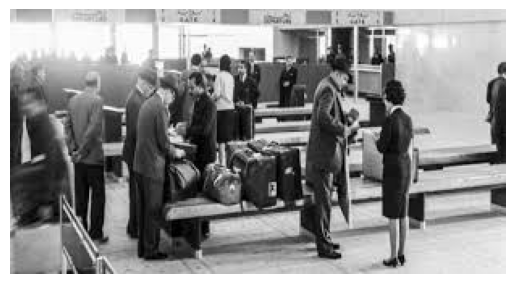

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
# Create a blob from the image
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

# Set the input for the network
net.setInput(blob)

# Get the output of the network
outs = net.forward(output_layers)

In [ ]:
# Process the Detections
class_ids = []
confidences = []
boxes = []

# Iterate over each detection output
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Calculate coordinates for the rectangle
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


# Apply Non-Max Suppression to remove overlapping bounding boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [ ]:
# Draw Bounding Boxes and Labels
font = cv2.FONT_HERSHEY_SIMPLEX

# Iterate over the detected objects and draw bounding boxes
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        confidence = confidences[i]
        label = f"{classes[class_ids[i]]}: {confidence:.2f}"
        color = (0, 255, 0)  # Green color for the bounding box

        # Draw the bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

        # Calculate the position for the text
        (text_width, text_height), baseline = cv2.getTextSize(label, font, 0.4, 1)
        y_text = y - 5 if y - 5 > text_height else y + text_height + 5

        # Draw the text background rectangle with transparency
        overlay = image.copy()
        cv2.rectangle(overlay, (x, y_text - text_height - 2), (x + text_width, y_text + baseline - 2), (0, 0, 0, 0.5), cv2.FILLED)
        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)

        # Draw the text on the image
        cv2.putText(image, label, (x, y_text - 2), font, 0.3, (255, 255, 255), 1)

In [ ]:
from matplotlib import pyplot as plt

# Define our imshow function
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size)) # size = h in real and size *aspect_ratio = w
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

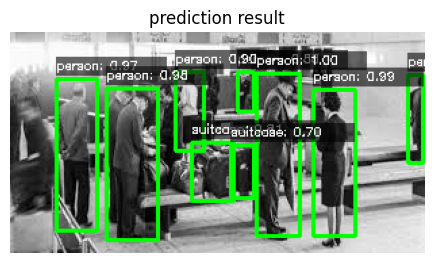

In [ ]:
# Display the image with bounding boxes and labels
imshow ('prediction result' ,image)

#Using Colab's Code Snippets let's access the webcam for an input

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [1]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

name 'take_photo' is not defined


In [ ]:
# Load an image using 'imread' specifying the path to image
image = cv2.imread('photo.jpg')
height, width, channels = image.shape

In [ ]:
# Create a blob from the image
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

# Set the input for the network
net.setInput(blob)

# Get the output of the network
outs = net.forward(output_layers)

In [ ]:
# Process the Detections
class_ids = []
confidences = []
boxes = []

# Iterate over each detection output
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Calculate coordinates for the rectangle
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


# Apply Non-Max Suppression to remove overlapping bounding boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [ ]:
# Draw Bounding Boxes and Labels
font = cv2.FONT_HERSHEY_SIMPLEX

# Iterate over the detected objects and draw bounding boxes
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        confidence = confidences[i]
        label = f"{classes[class_ids[i]]}: {confidence:.2f}"
        color = (0, 255, 0)  # Green color for the bounding box

        # Draw the bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

        # Calculate the position for the text
        (text_width, text_height), baseline = cv2.getTextSize(label, font, 0.4, 1)
        y_text = y - 5 if y - 5 > text_height else y + text_height + 5

        # Draw the text background rectangle with transparency
        overlay = image.copy()
        cv2.rectangle(overlay, (x, y_text - text_height - 2), (x + text_width, y_text + baseline - 2), (0, 0, 0, 0.5), cv2.FILLED)
        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)

        # Draw the text on the image
        cv2.putText(image, label, (x, y_text - 2), font, 0.4, (255, 255, 255), 1)

In [ ]:
from matplotlib import pyplot as plt

# Define our imshow function
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size)) # size = h in real and size *aspect_ratio = w
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

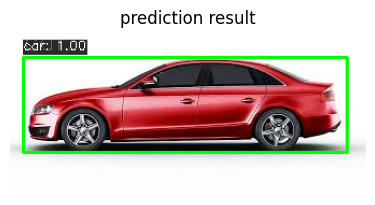

In [ ]:
# Display the image with bounding boxes and labels
imshow ('prediction result' ,image)